In [1]:
from pydicom import dcmread
import numpy as np
import pandas as pd
import os
import cv2
import keras
from matplotlib import pyplot as plt
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from keras import regularizers, optimizers
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from sklearn import metrics
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from keras.models import clone_model as clone
import random
import plotly.graph_objects as go

Using TensorFlow backend.


In [2]:
data_dir = '/home/aonghus/data/lawlor_group/AXR_JS_Files'
data = pd.read_csv('axr_data.csv')
data.head(3)

,filename,patient_id,study_level,label
0,jp1c1,1,1,1
1,jp1c0,1,0,0
2,jp2c0,2,0,0


In [3]:
def create_classifier(encoder, input_shape):
    
    
    encoder_ref = clone(encoder)
    encoder_ref.set_weights(encoder.get_weights())
        
    features = encoder_ref(encoder_ref.inputs)
    features = keras.layers.Dense(2048, activation='relu')(features)
    features = keras.layers.BatchNormalization()(features)
    features = keras.layers.Dense(512, activation='relu')(features)
    outputs = keras.layers.Dense(1, activation='sigmoid')(features)
    
    model = keras.Model(inputs = encoder_ref.inputs, outputs=outputs, name='AXR-Classifier')
    model.compile(
        optimizer=keras.optimizers.Adam(lr=0.0001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(),
                 keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

def create_siamese_encoder_from_simple(input_shape, simple_encoder, trainable=False, model_type='deepNN'):
    input_x1 = keras.layers.Input(shape = input_shape)
    input_x2 = keras.layers.Input(shape = input_shape)
    
    simple_encoder_ref = clone(simple_encoder)
    simple_encoder_ref.set_weights(simple_encoder.get_weights())
    simple_encoder_ref.trainable = trainable
    
    output_x1 = simple_encoder_ref(input_x1)
    output_x2 = simple_encoder_ref(input_x2)
    features = keras.layers.Lambda( lambda tensors : K.l2_normalize(tensors[0] - tensors[1]))( [output_x1 , output_x2] )
    outputs = keras.layers.Dense(2048, activation='relu')(features)
    siamese = keras.models.Model([input_x1, input_x2], outputs)
    return siamese

def create_simple_encoder(input_shape, base_model, model_type='deepNN', attach_convnet=False):
    inp = keras.layers.Input(shape=input_shape)
    prepend = None
    if attach_convnet:
        prepend = prepend_network()
    arm1 = arm(input_shape, base_model, name=model_type+'_arm', prepend_network=prepend)
    output = arm1(inp)
    model = keras.models.Model(inp, output)
    return model

def create_simple_classifier(encoder, input_shape, trainable=False):
    for layer in encoder.layers:
        layer.trainable = trainable
    
    features = encoder(encoder.inputs)
    features = keras.layers.Dense(2048, activation='relu')(features)
    features = keras.layers.BatchNormalization()(features)
    features = keras.layers.Dense(512, activation='relu')(features)
    outputs = keras.layers.Dense(1, activation='sigmoid')(features)
    
    model = keras.Model(inputs = encoder.inputs, outputs=outputs, name='AXR-Simple_Classifier')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(),
                 keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

def projection_head(encoder, input_shape):
    features = encoder(encoder.inputs)
    features = keras.layers.Dense(2048, activation='relu')(features)
    outputs = keras.layers.Dense(128, activation='relu')(features)
    model = keras.Model(inputs=encoder.inputs, outputs=outputs, name='AXR-projection-head')
    return model


def simple_projection_head(encoder, input_shape):
    features = encoder(encoder.inputs)
    #features = keras.layers.Lambda( lambda tensors : K.sqrt(K.sum(K.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))( [o1 , o2] )
    outputs = keras.layers.Dense(128, activation='relu')(features)
    model = keras.Model(inputs=encoder.inputs, outputs=outputs, name='AXR-projection-head')
    return model

def contrastive_loss(y_true, y_pred):
    margin = 2
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        #print('labels ', labels)
        #print('logits ', logits)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def create_match_table(patient_list, df):
    match_table = {}
    for patient in patient_list:
        pat_data = df[df.patient_id==patient]
        pat = {}
        pat['similar'] = pat_data[pat_data.study_level > 0].index.values
        pat['different'] = pat_data[pat_data.study_level < 1].index.values
        match_table[patient] = pat
    return match_table

from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

class DCMDataGenerator(DataFrameIterator):
    def __init__(self, *args, **kwargs):
        self.white_list_formats = ('','dcm')
        super(DCMDataGenerator, self).__init__(*args, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.directory = kwargs['directory']
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        batch_x = np.array([self.read_dcm(dcm_path, self.directory, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])
        batch_y = np.array(self.y.iloc[indices_array].astype(str))

        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)

        return batch_x, batch_y.astype(int)

    @staticmethod
    def read_dcm(dcm_path, directory, target_size=(512, 512), color_mode='rgb', margin=0.07):
        img_array = dcmread(os.path.join(directory, dcm_path)).pixel_array
        img_y = img_array.shape[1]
        # remove pixels 
        margin_pix = int(img_y*margin)
        img_array = img_array[:, margin_pix: img_y-margin_pix]
        img_array = cv2.resize(img_array, target_size, interpolation=cv2.INTER_AREA)
        img_array = cv2.normalize(img_array, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img_array = np.expand_dims(img_array, -1)
        if color_mode == 'rgb':
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        return img_array

In [25]:
train_patients = np.asarray([104,  82,  72,  17, 101,  19,  18,   9, 185, 174, 114, 128,  94,
        42, 161, 103, 129,  26, 188, 120, 119, 122,  49, 184,  69, 206,
       164,  92,  84, 170,  57,  41,  53, 169, 158,  24,  10, 190, 147,
        23,  73, 200,  48,  90, 153,  13,  30, 117, 106, 197, 191,  11,
       112,  65,  75, 126,  87,  95, 176,  45,  20, 179,  32,  44, 196,
         6, 175,   7,  68,  40,  97,  37,  96,  34,  39, 127, 156, 155,
       171, 113, 163,  46, 110, 204,  35, 195, 146,  93,   3,  52, 108,
        61,  63, 144, 121, 198,  47, 118, 134, 116,  98,  16, 132, 181,
       149,  51, 168,   8,  27, 124, 145,  50,  38,   1, 111,  203])
valid_patients = np.asarray([ 14, 159,   4,  58, 152,  22, 162, 208, 109,  86, 136, 123,  29,
        71, 180, 160, 193, 141, 172, 182,  66, 102, 125, 137, 207,  15,
       138,  62, 183, 105])
test_patients = np.asarray([  2,   5,  12,  21,  25,  28,  54,  55,  60,  64,  67,  74,  76,
        77,  79,  80,  81,  91, 100, 107, 130, 135, 139, 140, 142, 148,
       151, 157, 165, 166, 173, 186, 189, 192, 194, 201 ])

train_df = data[data.patient_id.isin(train_patients)]
valid_df = data[data.patient_id.isin(valid_patients)]
test_df = data[data.patient_id.isin(test_patients)]

train_match_table = create_match_table(train_patients, data)
valid_match_table = create_match_table(valid_patients, data)
test_match_table = create_match_table(test_patients, data)

In [ ]:
train_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
valid_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_generator = ImageDataGenerator()

opts = {
    'target_size': (224, 224),
    'color_mode': 'rgb',
    'directory': data_dir,
    'x_col': 'filename',
    'y_col': 'label',
    'class_mode': 'raw',
    'batch_size': 1,
}

data_gen = DCMDataGenerator(
dataframe = data,
image_data_generator = train_generator,
**opts
)

test_gen = DCMDataGenerator(
dataframe = data,
image_data_generator = test_generator,
**opts
)
vanilla_opts = {
    'target_size': (224, 224),
    'color_mode': 'rgb',
    'directory': data_dir,
    'x_col': 'filename',
    'y_col': 'label',
    'shuffle': True,
    'class_mode': 'raw',
    'batch_size': 4,
}
vanilla_train_gen = DCMDataGenerator(
dataframe = train_df,
image_data_generator = train_generator,
**vanilla_opts
)

vanilla_valid_gen = DCMDataGenerator(
dataframe = valid_df,
image_data_generator = train_generator,
**vanilla_opts
)

vanilla_test_gen = DCMDataGenerator(
dataframe = test_df,
image_data_generator = train_generator,
**opts
)


In [6]:
# load trained encoder model
simple_encoder = keras.models.load_model('./models/densenet_chexpertbase')
simple_encoder.trainable = True
simple_encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 6,953,856
Non-trainable params: 83,648
_________________________________________________________________


In [7]:
input_shape=(224, 224, 3)
simple_encoder_with_projection = simple_projection_head(simple_encoder, input_shape)
simple_encoder_with_projection.summary()

Model: "AXR-projection-head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
Total params: 7,168,704
Trainable params: 7,085,056
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
np.random.seed(123)
temperature = 0.08
learning_rate = 0.0001
simple_encoder_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = contrastive_loss
)
STEP_SIZE_TRAIN = vanilla_train_gen.n // vanilla_train_gen.batch_size
STEP_SIZE_VALID = vanilla_valid_gen.n // vanilla_valid_gen.batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/densenet_encoder_contrastive_training_1_redo.csv')
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/simple_encoder_with_projection_jsOnly_contrastive_1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
simple_encoder_with_projection.fit(x=vanilla_train_gen,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = vanilla_valid_gen, validation_steps=STEP_SIZE_VALID,
                            epochs=50, callbacks=[stopper, checkpointer, csvlogger]
                           )

In [9]:
simple_classifier = create_simple_classifier(simple_encoder, input_shape)
simple_classifier.summary()

Model: "AXR-Simple_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 1024)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 10,194,497
Trainable params: 3,152,897
Non-trainable params: 7,041,600
__________________________

In [ ]:
STEP_SIZE_TRAIN = vanilla_train_gen.n // vanilla_train_gen.batch_size
STEP_SIZE_VALID = vanilla_valid_gen.n // vanilla_valid_gen.batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/densenet_classifier_contrastive_1_redo.csv')
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/simple_classifier_with_projection_jsOnly_1812.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
simple_classifier.fit(x=vanilla_train_gen,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = vanilla_valid_gen, validation_steps=STEP_SIZE_VALID,
                            epochs=40, callbacks=[stopper, checkpointer, csvlogger]
                           )

In [11]:
def get_simple_feature_rep(f, generator, data_df):
    idxs = []
    reps = []
    ys=[]
    
    i=0
    for idx in data_df.index.values:
        bx, by = generator._get_batches_of_transformed_samples([idx])
        features = f(bx)
        reps.append(features[0])
        idxs.append(idx)
        ys.append(by[0])
        

    return (np.asarray(idxs), reps, np.asarray(ys))

def evaluate_simple(model, idxs,y_true, generator, verbose=False):
    y_pred = np.zeros(len(idxs))
    tps = np.zeros(len(idxs))
    tns = np.zeros(len(idxs))
    fns = np.zeros(len(idxs))
    fps = np.zeros(len(idxs))
    y_score = []
    i=0
    for i,idx in enumerate(idxs):
        bx, by_ = generator._get_batches_of_transformed_samples([idx])
        output = model.predict(bx).flatten()[0]
        op = y_true[i]
        if output > 0.5:
            pred = 1
        else:
            pred = 0
        if pred and pred != op:
            fps[i] = 1
        elif pred and pred == op:
            tps[i] = 1
        elif not pred and pred != op:
            fns[i] = 1
        else:
            tns[i] = 1
        y_pred[i] = pred
        y_score.append(output)
    evaluation = pd.DataFrame()
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    rocauc = metrics.roc_auc_score(y_true, y_score)
    evaluation = evaluation.append({'Matthews Correlation Coeff': mcc,
                                    'Accuracy': accuracy,
                                    'Precision': precision,
                                    'recall': recall,
                                    'AUC ROC': rocauc}, ignore_index=True)
    return evaluation, tns, tps, fns, fps

def plot_features(data, feats, tns, tps, fns, fps):
    ftps = feats[tps==1]
    ftns = feats[tns==1]
    ffns = feats[fns==1]
    ffps = feats[fps==1]
    tpstr = list(data[data.index.isin(idxs[tps==1])].filename)
    tnstr = list(data[data.index.isin(idxs[tns==1])].filename)
    fpstr = list(data[data.index.isin(idxs[fps==1])].filename)
    fnstr = list(data[data.index.isin(idxs[fns==1])].filename)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ftps[:,0], y=ftps[:,1],text=tpstr, name='True Positives', mode='markers'))
    fig.add_trace(go.Scatter(x=ftns[:,0], y=ftns[:,1],text=tnstr, name='True Negatives', mode='markers'))
    fig.add_trace(go.Scatter(x=ffps[:,0], y=ffps[:,1],text=fpstr, name='False Positives', mode='markers'))
    fig.add_trace(go.Scatter(x=ffns[:,0], y=ffns[:,1],text=fnstr, name='False Negatives', mode='markers'))
    fig.show()

def plot_features_siamese(data, feats, idxs, tns, tps, fns, fps):
    ftps = feats[tps==1]
    ftns = feats[tns==1]
    ffns = feats[fns==1]
    ffps = feats[fps==1]
    tpstr = list(zip(data.iloc[idxs[:,0][tps==1]].filename,data.iloc[idxs[:,1][tps==1]].filename))
    tnstr = list(zip(data.iloc[idxs[:,0][tns==1]].filename,data.iloc[idxs[:,1][tns==1]].filename))
    fpstr = list(zip(data.iloc[idxs[:,0][fps==1]].filename,data.iloc[idxs[:,1][fps==1]].filename))
    fnstr = list(zip(data.iloc[idxs[:,0][fns==1]].filename,data.iloc[idxs[:,1][fns==1]].filename))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ftps[:,0], y=ftps[:,1],text=tpstr, name='True Positives', mode='markers'))
    fig.add_trace(go.Scatter(x=ftns[:,0], y=ftns[:,1],text=tnstr, name='True Negatives', mode='markers'))
    fig.add_trace(go.Scatter(x=ffps[:,0], y=ffps[:,1],text=fpstr, name='False Positives', mode='markers'))
    fig.add_trace(go.Scatter(x=ffns[:,0], y=ffns[:,1],text=fnstr, name='False Negatives', mode='markers'))

    fig.show()  

In [12]:
f = K.function(simple_encoder.input, simple_encoder.output)
retval = get_simple_feature_rep(f, test_gen, test_df)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)
simple_classifier_result, tns, tps, fns, fps = evaluate_simple(simple_classifier, idxs,ys, test_gen, verbose=False)
simple_classifier_result

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.99871,0.971698,0.931206,0.973684,0.986667


# Siamese Networks

In [13]:
from random import randint
def biased_patient_wise_siamese_generator(data_generator, patient_list, match_table, batch_size, verbose=False):
    while True:
        batch_rx = []
        batch_lx = []
        y_final = []
        
        for i in range(batch_size):
            patient = random.choice(patient_list)
            same = randint(0,1)
            similars = match_table[patient]['similar']
            diffs = match_table[patient]['different']
            main_idx = random.choice(similars)
            
            if diffs.size == 0: # for cases where there are no 0 level studies
                pair_idx = random.choice(similars)
                same = 1
            else:
                if same:
                    pair_idx = random.choice(similars)
                else:
                    pair_idx = random.choice(diffs)
            if verbose:
                print(patient, main_idx, pair_idx, same)
            pair = data_generator._get_batches_of_transformed_samples([main_idx, pair_idx])
            
            batch_rx.append(pair[0][0])
            batch_lx.append(pair[0][1])
            y_final.append(same)
            
        batch_x = [np.asarray(batch_rx), np.asarray(batch_lx)]
        batch_y = np.asarray(y_final)
        
        yield batch_x, batch_y

def balanced_patient_wise_siamese_generator(data_generator, patient_list, match_table, batch_size, verbose=False):
    while True:
        batch_rx = []
        batch_lx = []
        y_final = []
        
        for i in range(batch_size):
            patient = random.choice(patient_list)
            same = randint(0,1)
            similars = match_table[patient]['similar']
            diffs = match_table[patient]['different']
            
            if diffs.size == 0: # for those cases where there are no 0 level studies
                main_idx = random.choice(similars)
                pair_idx = random.choice(similars)
                same = 1
            else:
                target = randint(0,1) # 0 for different, 1 for similars
                if target: # arm1 -> with beads, arm2 -> choice(with beads, without beads)
                    main_idx = random.choice(similars)
                    if same:
                        pair_idx = random.choice(similars)
                    else:
                        pair_idx = random.choice(diffs)
                else: # arm1 -> choice(with beads, without beads), arm2 -> with beads
                    pair_idx = random.choice(similars)
                    if same:
                        main_idx = random.choice(similars)
                    else:
                        main_idx = random.choice(diffs)
            if verbose:
                print(patient, main_idx, pair_idx, same)
            pair = data_generator._get_batches_of_transformed_samples([main_idx, pair_idx])
            
            batch_rx.append(pair[0][0])
            batch_lx.append(pair[0][1])
            y_final.append(same)
            
        batch_x = [np.asarray(batch_rx), np.asarray(batch_lx)]
        batch_y = np.asarray(y_final)
        
        yield batch_x, batch_y   

## Case 1 - Frozen Pretrained Densenet121 on CheXpert data, Trained contrastively

In [14]:
dnet_chexpert = keras.models.load_model('./models/densenet_chexpertbase')
dnet_chexpert.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


### Biased Training

In [15]:
batch_size = 4
biased_siamese_train_data = biased_patient_wise_siamese_generator( data_gen, train_patients, train_match_table, batch_size)
biased_siamese_valid_data = biased_patient_wise_siamese_generator( data_gen, valid_patients, valid_match_table, batch_size)

In [16]:
biased_siamese_frozen_densenet = create_siamese_encoder_from_simple( input_shape, dnet_chexpert, trainable=False, model_type='Dense121Network')
biased_siamese_frozen_densenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           functional_1[0][0]         

In [17]:
biased_siamese_frozen_densenet_with_projection = projection_head(biased_siamese_frozen_densenet, input_shape)
biased_siamese_frozen_densenet_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         9136704     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2048)         4196352     model_1[0][0]  

In [ ]:
temperature = 0.08
learning_rate = 0.0001
biased_siamese_frozen_densenet_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_frozen_densenet_with_projection_contrastive_training_redo.csv')
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly21218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_frozen_densenet_with_projection.fit(
    x=biased_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = biased_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, checkpointer, csvlogger])

In [19]:
biased_siamese_frozen_densenet.trainable=False
biased_siamese_frozen_cxp_classifier = create_classifier(biased_siamese_frozen_densenet, input_shape)
biased_siamese_frozen_cxp_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         9136704     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2048)         4196352     model_1[0][0]       

In [ ]:
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/siamese_classifier_jsOnly_frozen_binary_modTraining_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_frozen_cxp_classifier.fit(x=biased_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = biased_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper, checkpointer,csvlogger]
                           )

In [21]:
def get_siamese_feature_rep(f, generator, patient_list, data_df, match_table):
    idxs = []
    reps = []
    ys=[]
    
    i=0
    for patient in patient_list:
        same = randint(0,1)
        similars = match_table[patient]['similar']
        diffs = match_table[patient]['different']
        
        #print('patient : ' ,patient,'\tsudies: ', main_idx, pair_idx, '\tlabel', same)
        for main_idx in similars:
            for pair_idx in similars:
                pair = generator._get_batches_of_transformed_samples([main_idx, pair_idx])
                ip = [np.asarray([pair[0][0]]), np.asarray([pair[0][1]])]
                features = f(ip)
                reps.append(features[0])
                idxs.append((main_idx, pair_idx))
                ys.append(1)
                i=i+1
                
        for main_idx in similars:
            for pair_idx in diffs:
                pair = generator._get_batches_of_transformed_samples([main_idx, pair_idx])
                ip = [np.asarray([pair[0][0]]), np.asarray([pair[0][1]])]
                features = f(ip)
                reps.append(features[0])
                idxs.append((main_idx, pair_idx))
                ys.append(0)

    return (np.asarray(idxs), reps, np.asarray(ys))

def get_siamese_feature_reps(f, generator, idxs):
    reps = []
    for (main_idx, pair_idx) in idxs:
        pair = generator._get_batches_of_transformed_samples([main_idx, pair_idx])
        ip = [np.asarray([pair[0][0]]), np.asarray([pair[0][1]])]
        features = f(ip)
        reps.append(features[0])
    
    return reps

#def get_feature_rep(f, model, generator, patient_list, data_df):
def evaluate_siamese(model, idxs, y_true, data_generator, verbose=False):
    y_pred = np.zeros(len(idxs))
    tps = np.zeros(len(idxs))
    tns = np.zeros(len(idxs))
    fns = np.zeros(len(idxs))
    fps = np.zeros(len(idxs))
    y_score = []
    i=0
    for i,idx in enumerate(idxs):
        main_idx, pair_idx = idx
        pair = data_generator._get_batches_of_transformed_samples([main_idx, pair_idx])
        ip = [np.asarray([pair[0][0]]), np.asarray([pair[0][1]])]
        output = model.predict(ip).flatten()[0]
        op = y_true[i]
        if output > 0.5:
            pred = 1
        else:
            pred = 0
        if pred and pred != op:
            fps[i] = 1
        elif pred and pred == op:
            tps[i] = 1
        elif not pred and pred != op:
            fns[i] = 1
        else:
            tns[i] = 1
        y_pred[i] = pred
        y_score.append(output)
    evaluation = pd.DataFrame()
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    rocauc = metrics.roc_auc_score(y_true, y_score)
    evaluation = evaluation.append({'Matthews Correlation Coeff': mcc,
                                    'Accuracy': accuracy,
                                    'Precision': precision,
                                    'recall': recall,
                                    'AUC ROC': rocauc}, ignore_index=True)
    return evaluation, tns, tps, fns, fps

In [27]:
f = K.function(biased_siamese_frozen_densenet.input, biased_siamese_frozen_densenet.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [28]:
biased_siamese_frozen_cxp_eval, tns, tps, fns, fps = evaluate_siamese(biased_siamese_frozen_cxp_classifier, idxs, ys, test_gen)
biased_siamese_frozen_cxp_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.975962,0.949612,0.857413,0.989848,0.946602


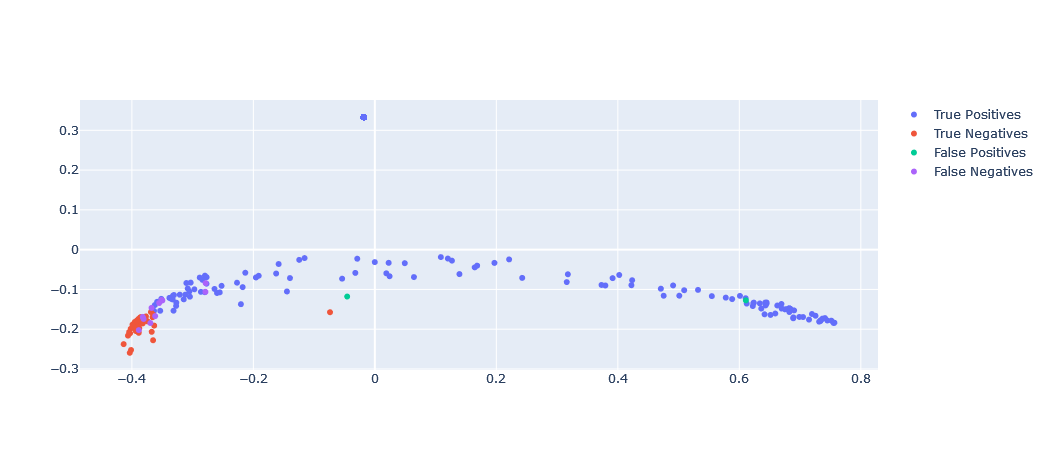

In [29]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

### Balanced Training

In [30]:
batch_size = 4
balanced_siamese_train_data = balanced_patient_wise_siamese_generator( data_gen, train_patients, train_match_table, batch_size)
balanced_siamese_valid_data = balanced_patient_wise_siamese_generator( data_gen, valid_patients, valid_match_table, batch_size)

In [31]:
balanced_siamese_frozen_densenet = create_siamese_encoder_from_simple( input_shape, dnet_chexpert, trainable=False, model_type='Dense121Network')
balanced_siamese_frozen_densenet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           functional_1[0][0]         

In [32]:

balanced_siamese_frozen_densenet_with_projection = projection_head(balanced_siamese_frozen_densenet, input_shape)
balanced_siamese_frozen_densenet_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 2048)         9136704     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2048)         4196352     model_4[0][0]  

In [33]:
temperature = 0.08
learning_rate = 0.0001
balanced_siamese_frozen_densenet_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_frozen_densenet_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_frozen_densenet_with_projection.fit(
    x=balanced_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = balanced_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])

Epoch 1/80
76/76 [==============================] - 40s 411ms/step - loss: 1.4566 - val_loss: 1.2980
Epoch 2/80
76/76 [==============================] - 28s 375ms/step - loss: 1.2382 - val_loss: 1.1952
Epoch 3/80
76/76 [==============================] - 27s 361ms/step - loss: 1.1861 - val_loss: 1.1027
Epoch 4/80
76/76 [==============================] - 27s 364ms/step - loss: 1.1631 - val_loss: 1.1665
Epoch 5/80
76/76 [==============================] - 27s 362ms/step - loss: 1.1566 - val_loss: 1.1508
Epoch 6/80
76/76 [==============================] - 27s 362ms/step - loss: 1.1977 - val_loss: 1.0046
Epoch 7/80
76/76 [==============================] - 27s 365ms/step - loss: 1.0281 - val_loss: 1.1888
Epoch 8/80
76/76 [==============================] - 28s 365ms/step - loss: 1.0380 - val_loss: 0.9441
Epoch 9/80
76/76 [==============================] - 27s 361ms/step - loss: 1.1632 - val_loss: 1.1671
Epoch 10/80
76/76 [==============================] - 28s 366ms/step - loss: 1.1554 - val_lo

In [34]:
balanced_siamese_frozen_densenet.trainable=False
balanced_siamese_frozen_cxp_classifier = create_classifier(balanced_siamese_frozen_densenet, input_shape)
balanced_siamese_frozen_cxp_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 2048)         9136704     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2048)         4196352     model_4[0][0]       

In [ ]:
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_frozen_cxp_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_frozen_cxp_classifier.fit(x=balanced_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = balanced_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper,checkpointer, csvlogger]
                           )

In [36]:
f = K.function(balanced_siamese_frozen_densenet.input, balanced_siamese_frozen_densenet.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [38]:
balanced_siamese_frozen_cxp_eval, tns, tps, fns, fps = evaluate_siamese(balanced_siamese_frozen_cxp_classifier, idxs, ys, test_gen)
balanced_siamese_frozen_cxp_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.973114,0.945736,0.852368,0.994845,0.936893


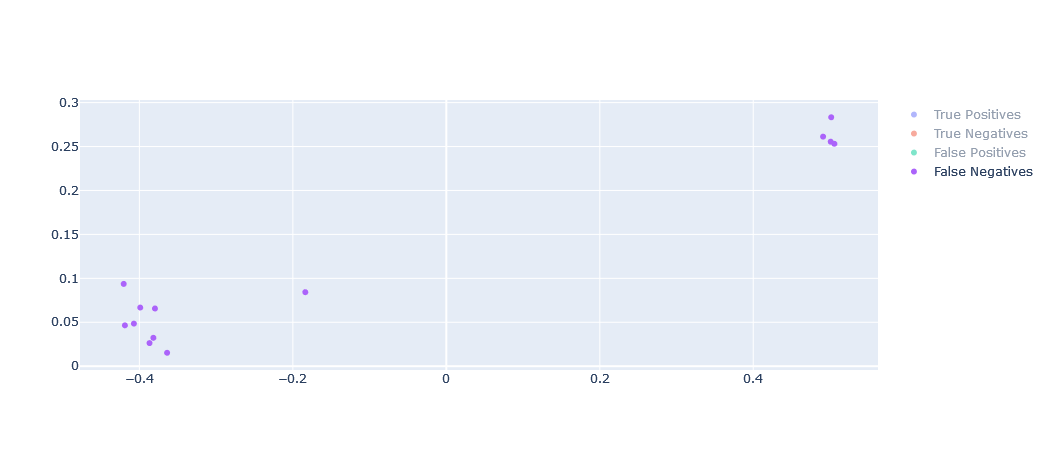

In [39]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

## Case 2 - Pretrained Densenet on Chexpert, Unfrozen contrastively trained

### Biased

In [40]:
dnet_chexpert2 = keras.models.load_model('./models/densenet_chexpertbase')
dnet_chexpert2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [41]:
biased_siamese_unfrozen_densenet = create_siamese_encoder_from_simple( input_shape, dnet_chexpert2, trainable=True, model_type='Dense121Network')
biased_siamese_unfrozen_densenet.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1024)         0           functional_1[0][0]         

In [42]:

biased_siamese_unfrozen_densenet_with_projection = projection_head(biased_siamese_unfrozen_densenet, input_shape)
biased_siamese_unfrozen_densenet_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 2048)         9136704     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2048)         4196352     model_6[0][0]  

In [43]:

temperature = 0.08
learning_rate = 0.0001
biased_siamese_unfrozen_densenet_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_unfrozen_densenet_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_unfrozen_densenet_with_projection.fit(
    x=biased_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = biased_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])

Epoch 1/80
76/76 [==============================] - 86s 924ms/step - loss: 1.2349 - val_loss: 1.1790
Epoch 2/80
76/76 [==============================] - 65s 862ms/step - loss: 1.0952 - val_loss: 1.0715
Epoch 3/80
76/76 [==============================] - 65s 857ms/step - loss: 1.1256 - val_loss: 1.0684
Epoch 4/80
76/76 [==============================] - 64s 845ms/step - loss: 0.9222 - val_loss: 1.2052
Epoch 5/80
76/76 [==============================] - 64s 842ms/step - loss: 1.1139 - val_loss: 1.0241
Epoch 6/80
76/76 [==============================] - 64s 847ms/step - loss: 0.9985 - val_loss: 1.1468
Epoch 7/80
76/76 [==============================] - 64s 848ms/step - loss: 1.0204 - val_loss: 1.1432
Epoch 8/80
76/76 [==============================] - 64s 850ms/step - loss: 0.9698 - val_loss: 1.0974
Epoch 9/80
76/76 [==============================] - 64s 847ms/step - loss: 1.0504 - val_loss: 1.1467
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping


In [44]:

biased_siamese_unfrozen_densenet.trainable = False
biased_siamese_unfrozen_cxp_classifier = create_classifier(biased_siamese_unfrozen_densenet, input_shape)
biased_siamese_unfrozen_cxp_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 2048)         9136704     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 2048)         4196352     model_6[0][0]       

In [ ]:

STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_unfrozen_cxp_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_unfrozen_cxp_classifier.fit(x=biased_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = biased_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper,checkpointer, csvlogger]
                           )

In [46]:

f = K.function(biased_siamese_unfrozen_densenet.input, biased_siamese_unfrozen_densenet.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [47]:
biased_siamese_unfrozen_cxp_eval, tns, tps, fns, fps = evaluate_siamese(biased_siamese_unfrozen_cxp_classifier, idxs, ys, test_gen)
biased_siamese_unfrozen_cxp_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.969007,0.94186,0.838944,0.989744,0.936893


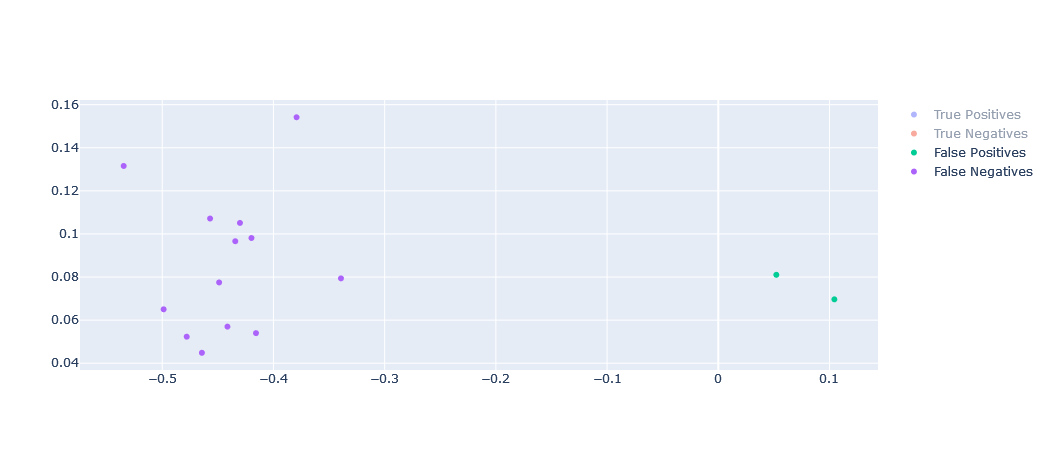

In [48]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

### Balanced Training

In [49]:
dnet_chexpert3 = keras.models.load_model('./models/densenet_chexpertbase')
dnet_chexpert3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [50]:
balanced_siamese_unfrozen_densenet = create_siamese_encoder_from_simple( input_shape, dnet_chexpert3, trainable=True, model_type='Dense121Network')
balanced_siamese_unfrozen_densenet.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1024)         0           functional_1[0][0]         

In [51]:

balanced_siamese_unfrozen_densenet_with_projection = projection_head(balanced_siamese_unfrozen_densenet, input_shape)
balanced_siamese_unfrozen_densenet_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 2048)         9136704     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 2048)         4196352     model_8[0][0]  

In [ ]:

temperature = 0.08
learning_rate = 0.0001
balanced_siamese_unfrozen_densenet_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_unfrozen_densenet_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_unfrozen_densenet_with_projection.fit(
    x=balanced_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = balanced_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])

In [53]:

balanced_siamese_unfrozen_densenet.trainable=False
balanced_siamese_unfrozen_cxp_classifier = create_classifier(balanced_siamese_unfrozen_densenet, input_shape)
balanced_siamese_unfrozen_cxp_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 2048)         9136704     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 2048)         4196352     model_8[0][0]       

In [ ]:

STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_unfrozen_cxp_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_unfrozen_cxp_classifier.fit(x=balanced_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = balanced_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper,checkpointer, csvlogger]
                           )

In [99]:

f = K.function(balanced_siamese_unfrozen_densenet.input, balanced_siamese_unfrozen_densenet.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [100]:

balanced_siamese_unfrozen_cxp_eval, tns, tps, fns, fps = evaluate_siamese(balanced_siamese_unfrozen_cxp_classifier, idxs, ys, test_gen)
balanced_siamese_unfrozen_cxp_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.981236,0.996124,0.987943,0.995169,1.0


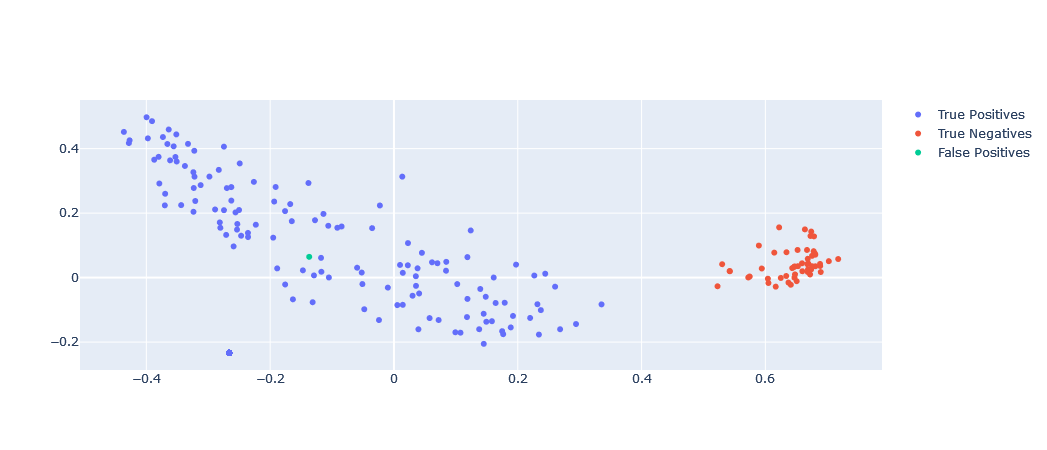

In [101]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

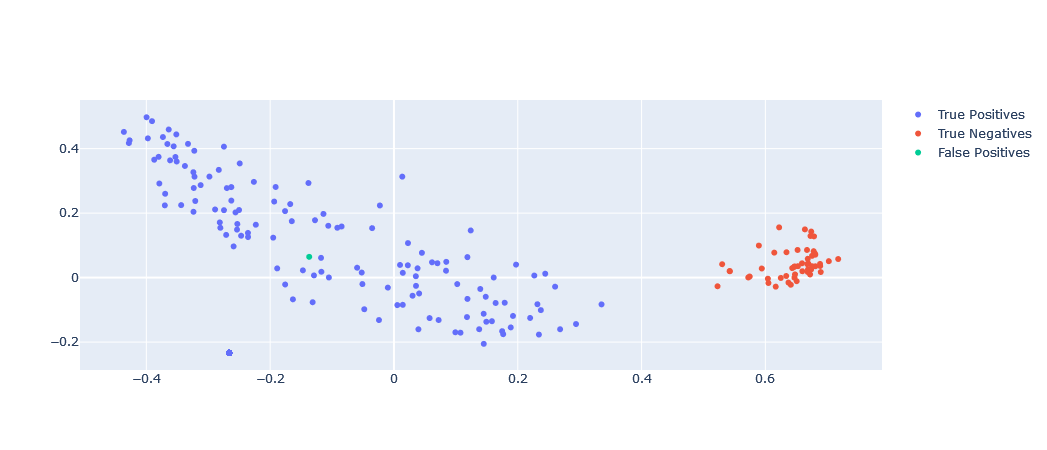

In [57]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

In [103]:
np.savez('./pca_features.npz', features=feats, indexes=idxs, true_negatives=tns, true_positives=tps, false_negatives=fns, false_positives=fps)

In [130]:
balanced_siamese_unfrozen_densenet.save('./weights/balanced_siamese_unfrozen_densenet_encoder.hdf5')

## Case 3 - AXR Pretrained frozen

### biased training

In [58]:
axr_dnet = clone(simple_encoder)
axr_dnet.set_weights(simple_encoder.get_weights())
axr_dnet.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [59]:
biased_siamese_frozen_axr = create_siamese_encoder_from_simple( input_shape, axr_dnet, trainable=False, model_type='Dense121Network')
biased_siamese_frozen_axr.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1024)         0           functional_1[0][0]        

In [60]:
biased_siamese_frozen_axr_with_projection = projection_head(biased_siamese_frozen_axr, input_shape)
biased_siamese_frozen_axr_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_10 (Functional)           (None, 2048)         9136704     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 2048)         4196352     model_10[0][0] 

In [ ]:
temperature = 0.08
learning_rate = 0.0001
biased_siamese_frozen_axr_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_frozen_axr_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_frozen_axr_with_projection.fit(
    x=biased_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = biased_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])

In [62]:
biased_siamese_frozen_axr.trainable=False
biased_siamese_frozen_axr_classifier = create_classifier(biased_siamese_frozen_axr, input_shape)
biased_siamese_frozen_axr_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_10 (Functional)           (None, 2048)         9136704     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 2048)         4196352     model_10[0][0]      

In [ ]:
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_frozen_axr_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_frozen_axr_classifier.fit(x=biased_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = biased_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper, checkpointer, csvlogger]
                           )

In [64]:
f = K.function(biased_siamese_frozen_axr.input, biased_siamese_frozen_axr.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [65]:
biased_siamese_frozen_axr_eval, tns, tps, fns, fps = evaluate_siamese(biased_siamese_frozen_axr_classifier, idxs, ys, test_gen)
biased_siamese_frozen_axr_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.992999,0.96124,0.889823,0.994949,0.956311


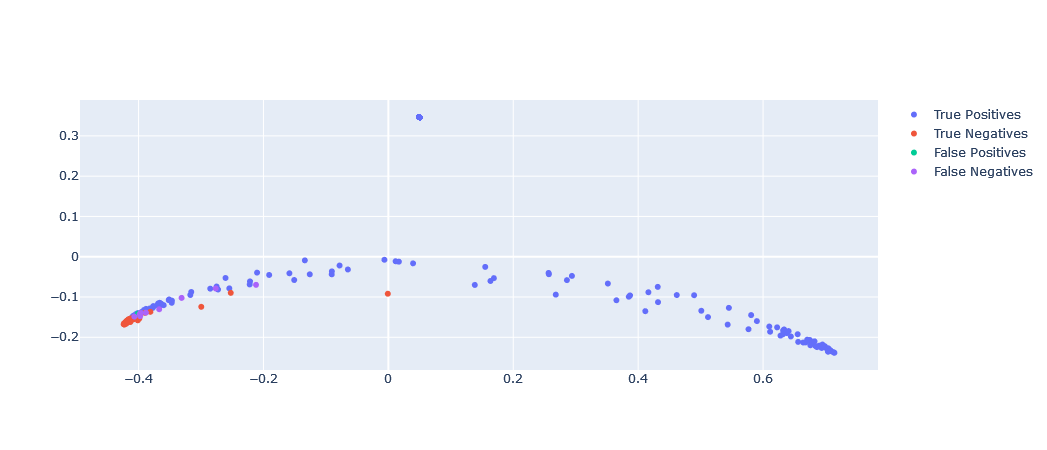

In [66]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

### Balanced Training

In [67]:
axr_dnet2 = clone(simple_encoder)
axr_dnet2.set_weights(simple_encoder.get_weights())
axr_dnet2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [68]:
balanced_siamese_frozen_axr = create_siamese_encoder_from_simple( input_shape, axr_dnet2, trainable=False, model_type='Dense121Network')
balanced_siamese_frozen_axr.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1024)         0           functional_1[0][0]        

In [69]:
balanced_siamese_frozen_axr_with_projection = projection_head(balanced_siamese_frozen_axr, input_shape)
balanced_siamese_frozen_axr_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_12 (Functional)           (None, 2048)         9136704     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 2048)         4196352     model_12[0][0] 

In [ ]:
temperature = 0.08
learning_rate = 0.0001
balanced_siamese_frozen_axr_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_frozen_axr_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_frozen_axr_with_projection.fit(
    x=balanced_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = balanced_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])

In [71]:
balanced_siamese_frozen_axr.trainable=False
balanced_siamese_frozen_axr_classifier = create_classifier(balanced_siamese_frozen_axr, input_shape)
balanced_siamese_frozen_axr_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_12 (Functional)           (None, 2048)         9136704     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 2048)         4196352     model_12[0][0]      

In [ ]:
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_frozen_axr_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_frozen_axr_classifier.fit(x=balanced_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = balanced_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper, checkpointer, csvlogger]
                           )

In [73]:
f = K.function(balanced_siamese_frozen_axr.input, balanced_siamese_frozen_axr.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [74]:
balanced_siamese_frozen_axr_eval, tns, tps, fns, fps = evaluate_siamese(balanced_siamese_frozen_axr_classifier, idxs, ys, test_gen)
balanced_siamese_frozen_axr_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.98497,0.957364,0.880153,0.994924,0.951456


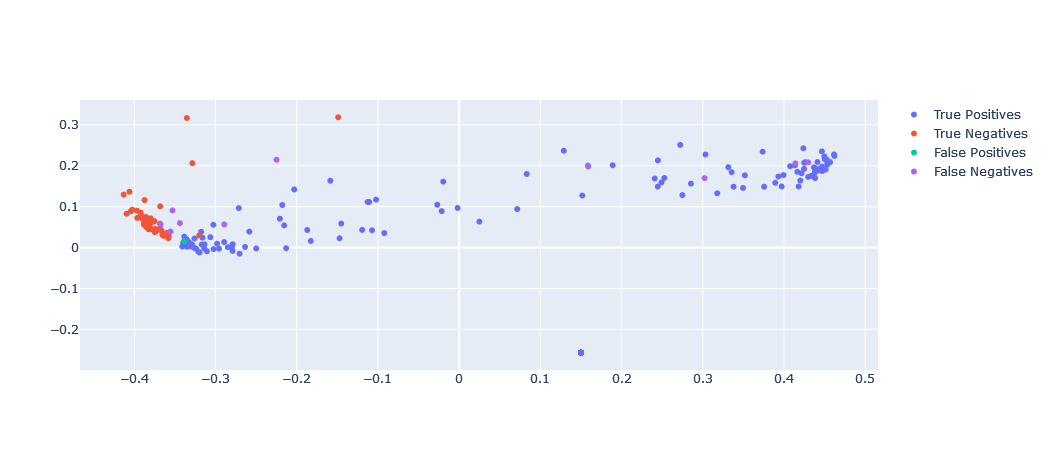

In [75]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

## Case 4 - AXR pretrained, Unfrozen

### Biased training

In [76]:
axr_dnet3 = clone(simple_encoder)
axr_dnet3.set_weights(simple_encoder.get_weights())
axr_dnet3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [77]:
biased_siamese_unfrozen_axr = create_siamese_encoder_from_simple( input_shape, axr_dnet3, trainable=True, model_type='Dense121Network')
biased_siamese_unfrozen_axr.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1024)         0           functional_1[0][0]        

In [78]:
biased_siamese_unfrozen_axr_with_projection = projection_head(biased_siamese_unfrozen_axr, input_shape)
biased_siamese_unfrozen_axr_with_projection.summary()

Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_14 (Functional)           (None, 2048)         9136704     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 2048)         4196352     model_14[0][0] 

In [ ]:
temperature = 0.08
learning_rate = 0.0001
biased_siamese_unfrozen_axr_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_unfrozen_axr_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_unfrozen_axr_with_projection.fit(
    x=biased_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = biased_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])


In [80]:
biased_siamese_unfrozen_axr.trainable = False
biased_siamese_unfrozen_axr_classifier = create_classifier(biased_siamese_unfrozen_axr, input_shape)
biased_siamese_unfrozen_axr_classifier.summary()

Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_14 (Functional)           (None, 2048)         9136704     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 2048)         4196352     model_14[0][0]      

In [ ]:
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/biased_siamese_unfrozen_axr_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
biased_siamese_unfrozen_axr_classifier.fit(x=biased_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = biased_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper, csvlogger]
                           )


In [82]:
f = K.function(biased_siamese_unfrozen_axr.input, biased_siamese_unfrozen_axr.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)

In [83]:
biased_siamese_unfrozen_axr_eval, tns, tps, fns, fps = evaluate_siamese(biased_siamese_unfrozen_axr_classifier, idxs, ys, test_gen)
biased_siamese_unfrozen_axr_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.987957,0.930233,0.817897,0.994737,0.917476


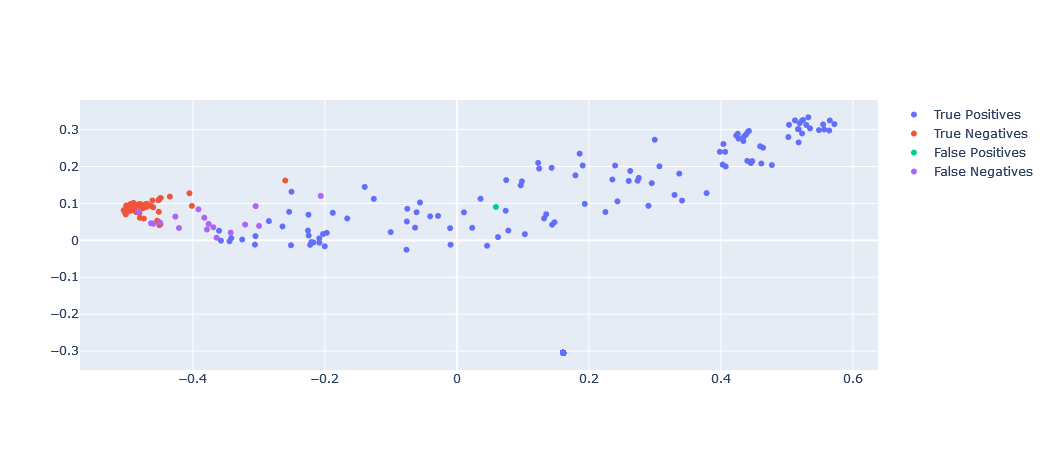

In [84]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

### Balanced training

In [85]:
axr_dnet4 = clone(simple_encoder)
axr_dnet4.set_weights(simple_encoder.get_weights())
axr_dnet4.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
DenseNet121_arm (Sequential) (None, 1024)              7037504   
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


In [86]:
balanced_siamese_unfrozen_axr = create_siamese_encoder_from_simple( input_shape, axr_dnet4, trainable=True, model_type='Dense121Network')
balanced_siamese_unfrozen_axr.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         7037504     input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 1024)         0           functional_1[0][0]        

In [87]:
balanced_siamese_unfrozen_axr_with_projection = projection_head(balanced_siamese_unfrozen_axr, input_shape)
balanced_siamese_unfrozen_axr_with_projection.summary()


Model: "AXR-projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_16 (Functional)           (None, 2048)         9136704     input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 2048)         4196352     model_16[0][0] 

In [88]:
temperature = 0.08
learning_rate = 0.0001
balanced_siamese_unfrozen_axr_with_projection.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss = SupervisedContrastiveLoss(temperature)
)
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_unfrozen_axr_with_projection_contrastive_training_redo.csv')
#checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_encoder_pretrained_chexpertbase_perUser_jsonly2.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_unfrozen_axr_with_projection.fit(
    x=balanced_siamese_train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data = balanced_siamese_valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=80,
    callbacks=[stopper, csvlogger])


Epoch 1/80
76/76 [==============================] - 84s 868ms/step - loss: 1.5361 - val_loss: 1.3456
Epoch 2/80
76/76 [==============================] - 64s 843ms/step - loss: 1.1456 - val_loss: 1.0315
Epoch 3/80
76/76 [==============================] - 63s 832ms/step - loss: 0.9777 - val_loss: 1.0696
Epoch 4/80
76/76 [==============================] - 63s 827ms/step - loss: 0.9359 - val_loss: 1.0859
Epoch 5/80
76/76 [==============================] - 63s 828ms/step - loss: 0.9713 - val_loss: 1.0827
Epoch 6/80
76/76 [==============================] - 63s 831ms/step - loss: 1.0482 - val_loss: 1.2229
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [89]:
balanced_siamese_unfrozen_axr.trainable=False
balanced_siamese_unfrozen_axr_classifier = create_classifier(balanced_siamese_unfrozen_axr, input_shape)
balanced_siamese_unfrozen_axr_classifier.summary()


Model: "AXR-Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_16 (Functional)           (None, 2048)         9136704     input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 2048)         4196352     model_16[0][0]      

In [90]:
STEP_SIZE_TRAIN = len(train_df) // batch_size
STEP_SIZE_VALID = len(valid_df) // batch_size
csvlogger = keras.callbacks.CSVLogger('./logs/balanced_siamese_unfrozen_axr_classifier_redo.csv', append=True)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5', verbose=1, save_best_only=True,monitor='val_loss')
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
balanced_siamese_unfrozen_axr_classifier.fit(x=balanced_siamese_train_data,steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data = balanced_siamese_valid_data, validation_steps=STEP_SIZE_VALID,
                            epochs=80, callbacks=[stopper, checkpointer, csvlogger]
                           )


Epoch 1/80
76/76 [==============================] - 43s 428ms/step - loss: 0.2942 - binary_accuracy: 0.9069 - auc_8: 0.9775 - precision_8: 0.9883 - recall_8: 0.8497 - val_loss: 0.6002 - val_binary_accuracy: 0.9000 - val_auc_8: 0.9313 - val_precision_8: 0.9318 - val_recall_8: 0.8913

Epoch 00001: val_loss improved from inf to 0.60022, saving model to ./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5
Epoch 2/80
76/76 [==============================] - 30s 393ms/step - loss: 0.1617 - binary_accuracy: 0.9292 - auc_8: 0.9840 - precision_8: 0.9695 - recall_8: 0.9123 - val_loss: 0.5763 - val_binary_accuracy: 0.8500 - val_auc_8: 0.9486 - val_precision_8: 0.8333 - val_recall_8: 0.9375

Epoch 00002: val_loss improved from 0.60022 to 0.57625, saving model to ./weights/siamese_classifier_jsOnly_frozen_binary1218.hdf5
Epoch 3/80
76/76 [==============================] - 30s 398ms/step - loss: 0.1097 - binary_accuracy: 0.9650 - auc_8: 0.9917 - precision_8: 0.9677 - recall_8: 0.9688 - val_los

In [91]:
f = K.function(balanced_siamese_unfrozen_axr.input, balanced_siamese_unfrozen_axr.output)
retval = get_siamese_feature_rep(f, test_gen, test_patients, data, test_match_table)
idxs = retval[0]
ys = retval[2]
feature_vecs = retval[1]
pca = PCA(n_components=2)
pca.fit(feature_vecs)
feats = pca.transform(feature_vecs)


In [92]:
balanced_siamese_unfrozen_axr_eval, tns, tps, fns, fps = evaluate_siamese(balanced_siamese_unfrozen_axr_classifier, idxs, ys, test_gen)
balanced_siamese_unfrozen_axr_eval

,AUC ROC,Accuracy,Matthews Correlation Coeff,Precision,recall
0,0.999907,0.957364,0.883924,1.0,0.946602


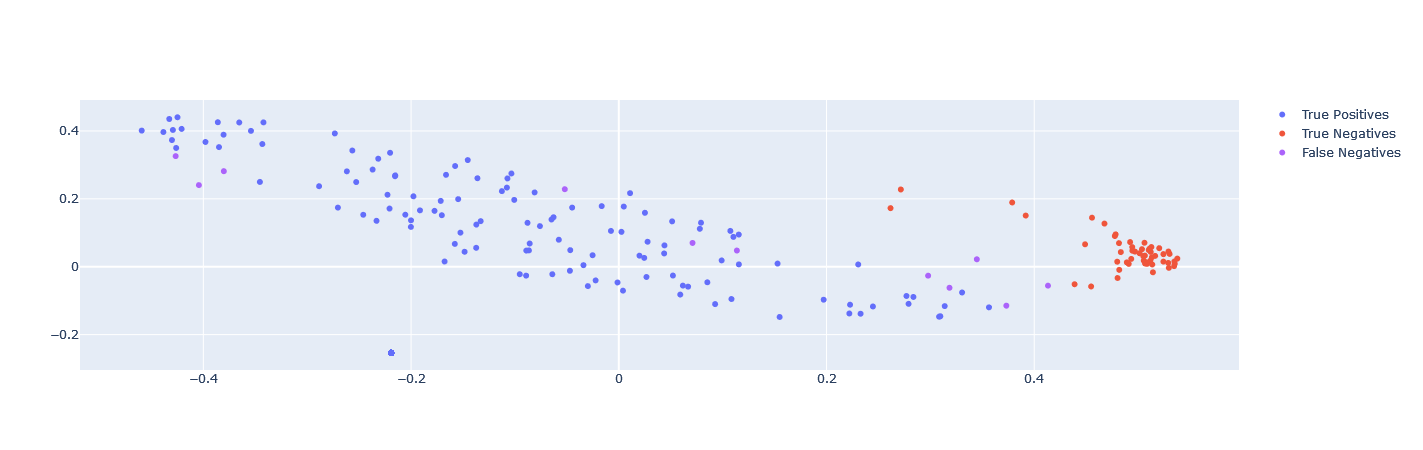

In [93]:
plot_features_siamese(data, feats, idxs, tns, tps, fns, fps)

In [127]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
def loss(output):
    return output[0][0]

def analyse_multi_siamese_saliency(input_img, models, save=False, name=None):
    subplot_args = { 'nrows': 2, 'ncols': len(models)+1, 'figsize': (5*len(models)+1, 8),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
    f, ax = plt.subplots(**subplot_args)
    maps = []
    for model in models:
        saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)
        # Generate saliency map with smoothing that reduce noise by adding noise
        saliency_map = saliency(loss,
                        input_img,
                        #smooth_samples=20, # The number of calculating gradients iterations.
                        #smooth_noise=0.20  # noise spread level.
                       )
        saliency_map1 = normalize(saliency_map[0])
        saliency_map2 = normalize(saliency_map[1])
        maps.append([np.reshape(saliency_map1, (224, 224)),np.reshape(saliency_map2, (224, 224))])
    
    ax[0, 0].imshow(input_img[0][0], cmap='gray')
    ax[1, 0].imshow(input_img[1][0], cmap='gray')
    for i,sal_map in enumerate(maps):
        ax[0, i+1].imshow(sal_map[0], cmap='jet')
        ax[1, i+1].imshow(sal_map[1], cmap='jet')
    f.tight_layout()
    if save:
        if name is None:
            f.savefig('saliency.jpg')
        f.savefig(name)

In [ ]:
def analyse_siamese_saliency(input_img, model):
    # Create Saliency object.
    saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)
    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss,
                        input_img,
                        #smooth_samples=20, # The number of calculating gradients iterations.
                        #smooth_noise=0.20  # noise spread level.
                       )
    
    saliency_map1 = normalize(saliency_map[0])
    saliency_map2 = normalize(saliency_map[1])
    subplot_args = { 'nrows': 2, 'ncols': 2, 'figsize': (15, 10),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
    f, ax = plt.subplots(**subplot_args)
    ax[0, 0].imshow(input_img[0][0], cmap='gray')
    ax[0, 1].imshow(np.reshape(saliency_map1, (224, 224)), cmap='jet')
    ax[1, 0].imshow(input_img[1][0], cmap='gray')
    ax[1, 1].imshow(np.reshape(saliency_map2, (224, 224)), cmap='jet')

In [ ]:
left_ip, y = test_gen._get_batches_of_transformed_samples([463])
right_ip, y =  test_gen._get_batches_of_transformed_samples([464])
ip = [left_ip, right_ip]
analyse_multi_siamese_saliency(ip,
                               [biased_siamese_frozen_cxp_classifier, biased_siamese_unfrozen_cxp_classifier], save=True,name='BiasedSaliency.jpg' )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


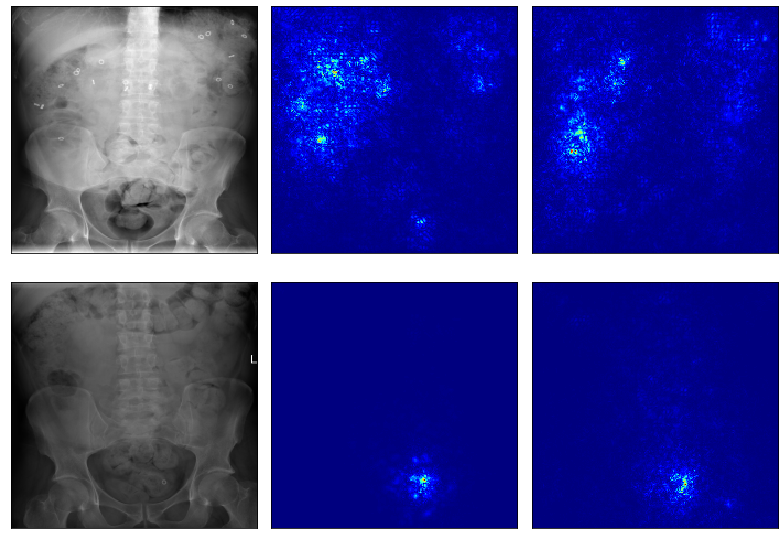

In [129]:
left_ip, y = test_gen._get_batches_of_transformed_samples([463])
right_ip, y =  test_gen._get_batches_of_transformed_samples([464])
ip = [left_ip, right_ip]
analyse_multi_siamese_saliency(ip,[balanced_siamese_frozen_cxp_classifier, balanced_siamese_unfrozen_cxp_classifier], save=True, name='BalancedSaliency.jpg')

In [118]:
data[data.patient_id == 189]

,filename,patient_id,study_level,label
459,jp189c3,189,3,1
460,jp189c4,189,4,1
461,jp189c5,189,5,1
462,jp189c2,189,2,1
463,jp189c6,189,6,1
464,jp189c1,189,1,1


In [95]:
list_results = [('Simple Classifier', simple_classifier_result),
                ('Biased Vanilla Frozen', biased_siamese_frozen_cxp_eval),
                ('Biased Vanilla unfrozen', biased_siamese_unfrozen_cxp_eval),
                ('Balanced Vanilla Frozen', balanced_siamese_frozen_cxp_eval),
                ('Balanced Vanilla unfrozen', balanced_siamese_unfrozen_cxp_eval),
                ('Biased AXR Frozen', biased_siamese_frozen_axr_eval),
                ('Biased AXR unfrozen', biased_siamese_unfrozen_axr_eval),
                ('Balanced AXR Frozen', balanced_siamese_frozen_axr_eval),
                ('Balanced AXR unfrozen', balanced_siamese_unfrozen_axr_eval)]

In [97]:
test_data = []
for method, evaluation in list_results:
    test_data.append({'Model': method,
                     'AUC': evaluation['AUC ROC'][0],
                     'Accuracy': evaluation['Accuracy'][0],
                     'MCC': evaluation['Matthews Correlation Coeff'][0],
                     'Precision': evaluation['Precision'][0],
                     'Recall': evaluation['recall'][0]})
test_data_df = pd.DataFrame(test_data)

In [98]:
test_data_df

,Model,AUC,Accuracy,MCC,Precision,Recall
0,Simple Classifier,0.998710,0.971698,0.931206,0.973684,0.986667
1,Biased Vanilla Frozen,0.975962,0.949612,0.857413,0.989848,0.946602
2,Biased Vanilla unfrozen,0.969007,0.941860,0.838944,0.989744,0.936893
3,Balanced Vanilla Frozen,0.973114,0.945736,0.852368,0.994845,0.936893
4,Balanced Vanilla unfrozen,0.981236,0.996124,0.987943,0.995169,1.000000
5,Biased AXR Frozen,0.992999,0.961240,0.889823,0.994949,0.956311
6,Biased AXR unfrozen,0.987957,0.930233,0.817897,0.994737,0.917476
7,Balanced AXR Frozen,0.984970,0.957364,0.880153,0.994924,0.951456
8,Balanced AXR unfrozen,0.999907,0.957364,0.883924,1.000000,0.946602


In [136]:
print("hello")

hello


In [135]:
from keras.utils.vis_utils import plot_model

In [137]:
balanced_siamese_frozen_cxp_classifier.save('./models_SPOT_MAIN/balanced_siamese_frozen_cxp_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/balanced_siamese_frozen_cxp_classifier/assets


In [139]:
balanced_siamese_unfrozen_cxp_classifier.save('./models_SPOT_MAIN/balanced_siamese_unfrozen_cxp_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/balanced_siamese_unfrozen_cxp_classifier/assets


In [140]:
biased_siamese_frozen_cxp_classifier.save('./models_SPOT_MAIN/biased_siamese_frozen_cxp_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/biased_siamese_frozen_cxp_classifier/assets


In [141]:
biased_siamese_unfrozen_cxp_classifier.save('./models_SPOT_MAIN/biased_siamese_unfrozen_cxp_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/biased_siamese_unfrozen_cxp_classifier/assets


In [143]:
balanced_siamese_unfrozen_axr_classifier.save('./models_SPOT_MAIN/balanced_siamese_unfrozen_axr_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/balanced_siamese_unfrozen_axr_classifier/assets


In [144]:
balanced_siamese_frozen_axr_classifier.save('./models_SPOT_MAIN/balanced_siamese_frozen_axr_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/balanced_siamese_frozen_axr_classifier/assets


In [145]:
biased_siamese_unfrozen_axr_classifier.save('./models_SPOT_MAIN/biased_siamese_unfrozen_axr_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/biased_siamese_unfrozen_axr_classifier/assets


In [146]:
biased_siamese_frozen_axr_classifier.save('./models_SPOT_MAIN/balanced_siamese_frozen_axr_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/balanced_siamese_frozen_axr_classifier/assets


In [147]:
simple_classifier.save('./models_SPOT_MAIN/simple_classifier')

INFO:tensorflow:Assets written to: ./models_SPOT_MAIN/simple_classifier/assets
